# HW 3

## Problem 1

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
Omega_m0 = .3
Omega_lambda = .7

def omega_m(z):
    return (Omega_m0*(1+z)**3) / (Omega_m0*(1+z)**3 + Omega_lambda)

def delta_vir(z):
    return 18*np.pi**2 + 82*(omega_m(z)-1) - 39*(omega_m(z)-1)**2

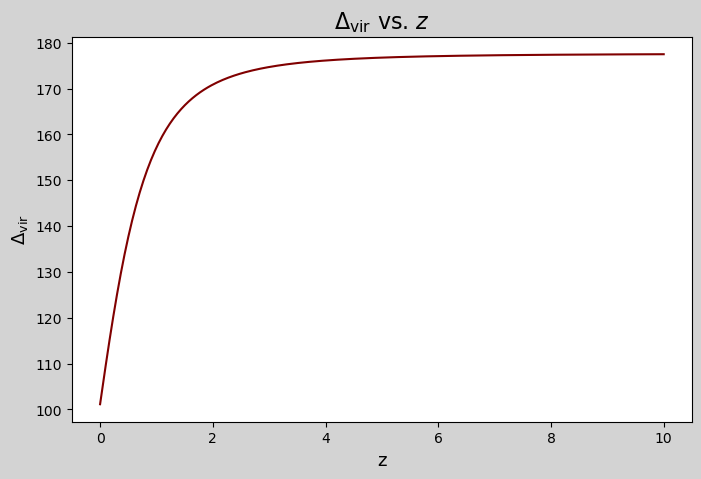

In [3]:
zs = np.linspace(0,10,300)
delta_virs = delta_vir(zs)

fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title("$\Delta_{\mathrm{vir}}$ vs. $z$", fontsize=16)
ax.set_xlabel('z', fontsize=13)
ax.set_ylabel("$\Delta_{\mathrm{vir}}$", fontsize=13)
ax.plot(zs, delta_virs, c="maroon")

In [4]:
h = .7 #
H_0 = 100*h #km s^-1 Mpc^-1
H_0 = H_0 / 3.09e19 # s^-1
G = 6.67*10**-8 # cm^3 g^-1 s^-2
M = 1e12 * 1.989e33 # g

def rho_crit(z):
    return 3 * H_0**2 * (Omega_m0*(1+z)**3 + Omega_lambda)/(8*np.pi*G)

def r_vir(M, z):
    # give M in grams
    return ((.75*M) / (rho_crit(z)*delta_vir(z))*np.pi*omega_m(z))**(1/3)

z	r_vir [cm]
0	1.15e+24
1	9.33e+23
3	5.21e+23
6	3.02e+23
10	1.93e+23


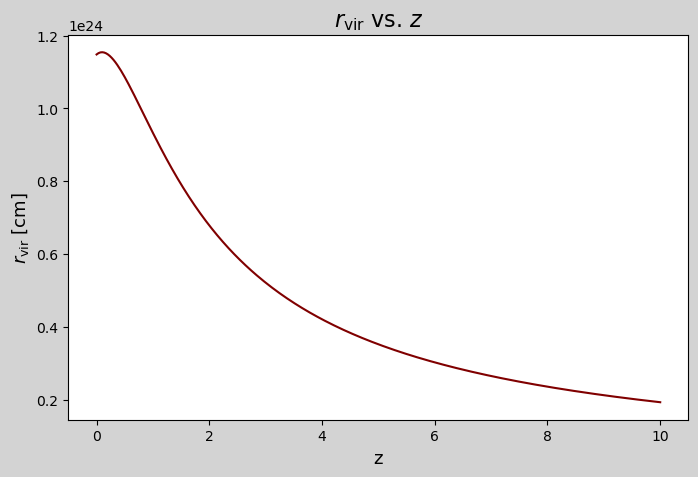

In [5]:
r_virs = r_vir(M, zs)

fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title("$r_{\mathrm{vir}}$ vs. $z$", fontsize=16)
ax.set_xlabel('z', fontsize=13)
ax.set_ylabel("$r_{\mathrm{vir}}$ [cm]", fontsize=13)
ax.plot(zs, r_virs, c="maroon")

notable_zs = [0,1,3,6,10]
print("z\tr_vir [cm]")
for z in notable_zs:
    print(f"{z}\t{r_vir(M,z):.2e}")

## Problem 2

In [6]:
from colossus.cosmology import cosmology
from colossus.halo import concentration
cosmo = cosmology.setCosmology('planck15')

In [7]:
def rho(r, z=0, M=M):
    c_vir = concentration.concentration(M=M/1.989e33, z=z, mdef="vir", model="diemer15_orig")
    denom = 4 * np.pi * (r_vir(M,z)/c_vir)**3 * (np.log(1+c_vir) - c_vir/(1+c_vir))
    denom *= (c_vir/r_vir(M,z)) * r * (1+(c_vir/r_vir(M,z))*r)**2

    return M / denom

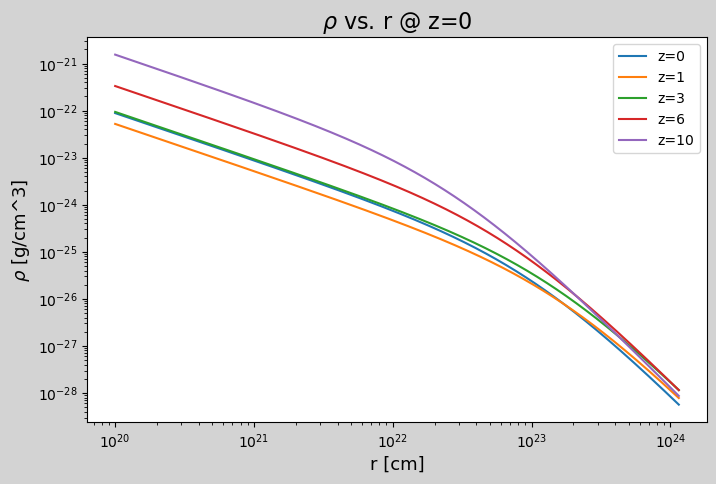

In [8]:
fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title(r"$\rho$ vs. r @ z=0", fontsize=16)
ax.set_xlabel('r [cm]', fontsize=13)
ax.set_ylabel(r"$\rho$ [g/cm^3]", fontsize=13)
ax.set_yscale('log')
ax.set_xscale('log')

rs = np.logspace(20, np.log10(r_vir(M,0)), 10000)

for z in notable_zs:
    rhos = rho(rs, z=z)
    ax.plot(rs, rhos, label=f"z={z}")

ax.legend()

In [9]:
from scipy import interpolate

def r_d(d=200, M=M, z=0):
    rs = np.logspace(20, np.log10(r_vir(M=M,z=z)), 10000)
    rhos = rho(rs, z=z)
    r = interpolate.interp1d(rhos, rs)

    rho_d = d*omega_m(z)*rho_crit(z)
    return r(rho_d)

In [10]:
z=0
this_r_vir = r_vir(M,z)
print(f"r_vir = {this_r_vir:.2e} cm\nz = 0\n")
print("d\t\tr_d [cm]\t\tr_d/r_vir")
for d in [200,500,2500]:
    this_r_d = r_d(d=d, M=M, z=z)
    print(f"{d}\t\t{this_r_d:.2e}\t\t{this_r_d/this_r_vir:.2f}")


r_vir = 1.15e+24 cm
z = 0

d		r_d [cm]		r_d/r_vir
200		5.02e+23		0.44
500		3.52e+23		0.31
2500		1.80e+23		0.16


In [11]:
z=6
this_r_vir = r_vir(M,z)
print(f"r_vir = {this_r_vir:.2e}\nz = 6\n")
print("d\t\tr_d [cm]\t\tr_d/r_vir")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,M=M,z=z)
    print(f"{d}\t\t{this_r_d:.2e}\t\t{this_r_d/this_r_vir:.2f}")

r_vir = 3.02e+23
z = 6

d		r_d [cm]		r_d/r_vir
200		5.78e+22		0.19
500		3.40e+22		0.11
2500		1.09e+22		0.04


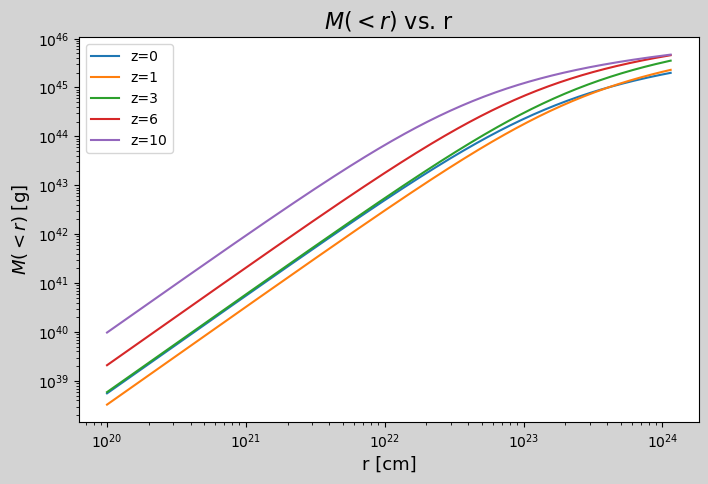

In [12]:
from scipy.integrate import quad

# def m_internal(r, z=0, M=M):
#     def integrand(r):
#         return 4*np.pi * r**2 * rho(r, z=z, M=M)
#     return quad(integrand, 0, r,)[0]

def m_internal(r, z=0, M=M):
    r_v = r_vir(M,z)
    c_v = concentration.concentration(M=M/1.989e33, z=z, mdef="vir", model="diemer15_orig")

    numerator = np.log(1+(r*c_v/r_v)) - ((r*c_v/(r_v+r*c_v)))
    denom = np.log(1+c_v) - c_v/(1+c_v)
    
    return M*numerator/denom

fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title(r"$M(<r)$ vs. r", fontsize=16)
ax.set_xlabel('r [cm]', fontsize=13)
ax.set_ylabel(r"$M(<r)$ [g]", fontsize=13)
ax.set_yscale('log')
ax.set_xscale('log')

rs = np.logspace(20, np.log10(r_vir(M,0)), 300)

for z in notable_zs:
    phis = [m_internal(r,M=M,z=z) for r in rs]
    ax.plot(rs, phis, label=f"z={z}")

ax.legend()

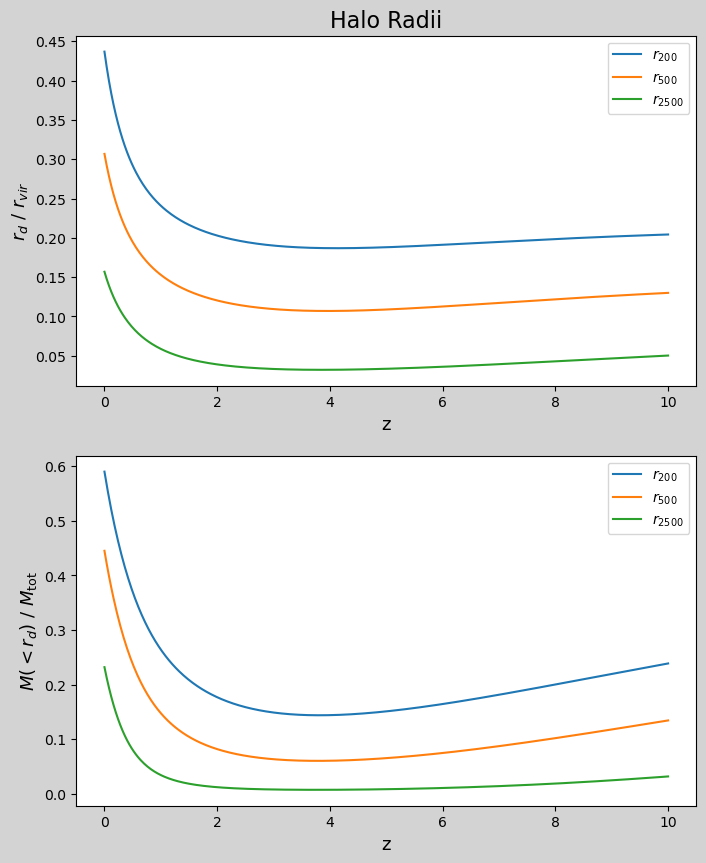

In [13]:
zs = np.linspace(0,10,500)
r_virs = r_vir(M,zs)
ds = [200,500,2500]

fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(8,10))
fig.set_facecolor('lightgray')
axes[0].set_title("Halo Radii", fontsize=16)
axes[0].set_xlabel('z', fontsize=13)
axes[0].set_ylabel("$r_d$ / $r_{vir}$", fontsize=13)

axes[1].set_xlabel('z', fontsize=13)
axes[1].set_ylabel("$M(<r_d)$ / $M_{\mathrm{tot}}$", fontsize=13)

for d in ds:
    r_ds = [r_d(d=d, M=M, z=z) for z in zs]
    Ms = np.array([m_internal(r_ds[i],z) for i,z in enumerate(zs)])
    axes[0].plot(zs, r_ds/r_virs, label=f"$r_{{{d}}}$")
    axes[1].plot(zs, Ms/M, label=f"$r_{{{d}}}$")

axes[0].legend()
axes[1].legend()

In [14]:
z = 0
this_r_vir = r_vir(M,z)
print(f"M = {M:.2e} g, z = {z}\n")
print("d\t\tM(<r_d) [g]\t\tM(<r_d)/M_tot")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,z=z)
    m_int = m_internal(this_r_d, z=z)
    print(f"{d}\t\t{m_int:.2e}\t\t{m_int/M:.2f}")


M = 1.99e+45 g, z = 0

d		M(<r_d) [g]		M(<r_d)/M_tot
200		1.17e+45		0.59
500		8.85e+44		0.45
2500		4.61e+44		0.23


In [15]:
z = 6
this_r_vir = r_vir(M,z)
print(f"M = {M:.2e} g, z = {z}\n")
print("d\t\tM(<r_d) [g]\t\tM(<r_d)/M_tot")
for d in [200,500,2500]:
    this_r_d = r_d(d=d,z=z)
    m_int = m_internal(this_r_d, z=z)
    print(f"{d}\t\t{m_int:.2e}\t\t{m_int/M:.2f}")

M = 1.99e+45 g, z = 6

d		M(<r_d) [g]		M(<r_d)/M_tot
200		3.27e+44		0.16
500		1.48e+44		0.07
2500		2.08e+43		0.01


## Problem 3

In [18]:
# def phi(r, M=M, z=0):
#     def integrand(r):
#         return G*m_internal(r, M=M, z=z)/(r**2)
    
#     return quad(integrand, r, r*100, limit=1000)[0]

# def phi(r, M=M, z=0):
#     c_v = concentration.concentration(M=M/1.989e33, z=z, mdef="vir", model="diemer15_orig")
#     r_v = r_vir(M,z)

#     A = (c_v*G*M)/(np.log(1+c_v) - (c_v/(1+c_v)))

#     def integrand1(x):
#         return x**-2 * np.log(1+(x/r_v))
    
#     def integrand2(x):
#         return x**-1/(r_v+x)
    
#     x_min = c_v * r
#     x_max = x_min*100
#     B = quad(integrand1, x_min, x_max)[0]
#     C = quad(integrand2, x_min, x_max)[0]

#     return A*(B-C)

def phi(r, M=M, z=0):
    c_v = concentration.concentration(M=M/1.989e33, z=z, mdef="vir", model="diemer15_orig")
    r_v = r_vir(M,z)
    numerator = -G*M*np.log(1+(r*c_v/r_v))
    denom = r * (np.log(1+c_v) - c_v/(1+c_v))

    return numerator/denom

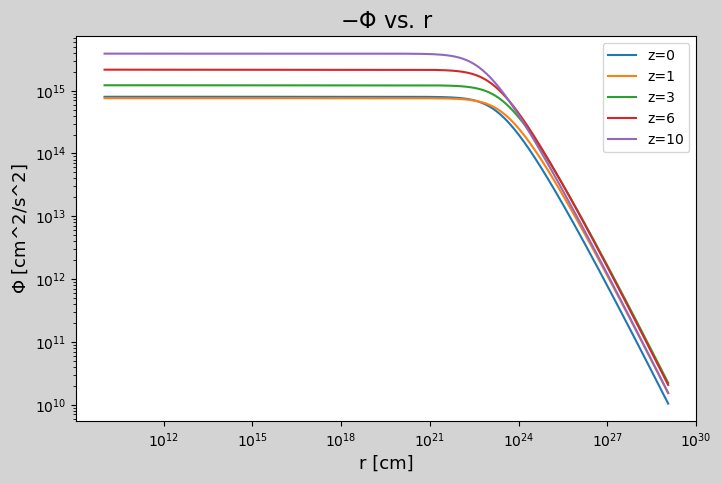

In [30]:
fig,ax = plt.subplots(1, figsize=(8,5))
fig.set_facecolor('lightgray')
ax.set_title(r"$-\Phi$ vs. r", fontsize=16)
ax.set_xlabel('r [cm]', fontsize=13)
ax.set_ylabel(r"$\Phi$ [cm^2/s^2]", fontsize=13)
ax.set_yscale('log')
ax.set_xscale('log')

rs = np.logspace(10, 5 + np.log10(r_vir(M,0)), 1000)

for z in notable_zs:
    phis = [-phi(r,M=M,z=z) for r in rs]
    ax.plot(rs, phis, label=f"z={z}")

ax.legend()

In [37]:
def v_circ(r, M=M, z=0):
    return np.sqrt(G*m_internal(r)/2)

mu = .59
m_p = 1.672e-24 # grams
k_B = 1.3807e-16 # cm^2 g s^-2 K^-1

def T_vir(M=M, z=0):
    r_v = r_vir(M, z)
    return (mu*m_p/(2*k_B)) * v_circ(r_v)**2

solar_mass = 1.989e33 # g
notable_Ms = np.array([1e12, 1e14]) * solar_mass

print("M[g]\t\tz\tv_vir[cm/s]\t\tT_vir[K]")

for M in notable_Ms:
    for z in notable_zs:
        print(f"{M:.2e}\t{z}\t{v_circ(r_vir(M,z)):.2e}\t\t{T_vir(M,z):.2e}")

M[g]		z	v_vir[cm/s]		T_vir[K]
1.99e+45	0	8.14e+18		2.37e+29
1.99e+45	1	7.68e+18		2.11e+29
1.99e+45	3	6.35e+18		1.44e+29
1.99e+45	6	5.08e+18		9.22e+28
1.99e+45	10	4.07e+18		5.92e+28
1.99e+47	0	1.12e+19		4.52e+29
1.99e+47	1	1.09e+19		4.21e+29
1.99e+47	3	9.72e+18		3.38e+29
1.99e+47	6	8.58e+18		2.63e+29
1.99e+47	10	7.59e+18		2.06e+29


## Problem 4